# 06 Eye-Tracking Event Analysis

## Overview
This notebook analyzes **eye-tracking data** from SR Research EyeLink recordings, synchronizing gaze behavior with experimental events.

**Purpose:**
- Load and parse EyeLink EDF files containing gaze coordinates and pupil size measurements
- Synchronize eye-tracking timestamps with experimental stimulus presentation (AI_Response.started events)
- Extract eye-tracking features for each trial to analyze reading behavior and cognitive load

**What it does:**
1. Loads session mapping (from Notebook 01) to identify which sessions have eye-tracking data
2. For each matched session:
   - Parses the corresponding EDF file to extract gaze position (X, Y coordinates) and pupil sizes
   - Synchronizes eye-tracking timestamps with experiment event timestamps
   - Segments eye-tracking data by trial based on AI_Response.started markers
   - Validates gaze positions within the defined Region of Interest (ROI) for text stimuli
3. Computes eye-tracking features per trial:
   - **Fixations:** duration, count, spatial dispersion, time to first fixation
   - **Saccades:** amplitude, duration, frequency
   - **Pupil metrics:** mean size, Index of Pupillary Activity (IPA)
4. Saves extracted features for statistical analysis

**Output:**
- `session_00-eye-features.pkl`, `session_01-eye-features.pkl`, etc.
- Each file contains trial-level eye-tracking features ready for analysis

**Next step:** Use features to analyze differences across alignment conditions or correlate with EEG/behavioral measures.

**Code Attribution:**
- Original eye-tracking analysis code adapted from: Chiossi, F., Mayer, S., & Ou, C. (2024). MobileHCI 2024 Papers - Submission 7226.
- OSF Repository: https://osf.io/fncj4/overview (Created: Sep 11, 2023)
- License: GNU General Public License (GPL) 3.0
- Code has been modified and extended for session-based processing and alignment with EEG data.

**Note:** This notebook requires preprocessing of EDF files to ASC format using SR Research tools (edf2asc).

## 1. Import Libraries and Setup

In [1]:
import numpy as np
import pandas as pd
import glob
from pathlib import Path

from matplotlib import pyplot as plt
import matplotlib.patches as patches

# Suppress tqdm ipywidgets warning
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='tqdm')

from tqdm.auto import tqdm

c:\Users\kimbe\iCloudDrive\Master\Masterarbeit\Analyse\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## 2. Load Session Mapping

# Load session mapping for eye-tracking data
df_sessions = pd.read_csv('./session_mapping.csv')

# Filter sessions with EEG match (eye-tracking available)
df_matched = df_sessions[df_sessions['eeg_file'] != 'NO MATCH'].copy()

# Extract session IDs
session_ids = df_matched.index.tolist()
print(f'Available sessions: {session_ids}')
print(f'Number of sessions: {len(session_ids)}')

# Show session info
print('\nSession details:')
print(df_matched[['experiment_file', 'n_trials', 'coverage']])

Available sessions: [0, 1, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15]
Number of sessions: 13

Session details:
                                      experiment_file  n_trials coverage
0   01_human-llm-alignment_2025-11-17_11h36.44.912...        50   120.5%
1   01_human-llm-alignment_2025-11-20_13h16.37.791...        39    79.3%
4   01_human-llm-alignment_2025-11-24_14h13.05.529...        49    54.7%
5   01_human-llm-alignment_2025-11-27_09h44.35.888...        16    45.7%
6   01_human-llm-alignment_2025-11-27_10h18.29.349...        20   100.0%
7   01_human-llm-alignment_2025-11-27_10h49.01.727...        50    85.2%
9   01_human-llm-alignment_2025-11-27_12h50.01.880...        47    90.6%
10  01_human-llm-alignment_2025-12-01_09h17.38.489...        43    58.3%
11  01_human-llm-alignment_2025-12-01_10h17.52.885...        50    31.2%
12  01_human-llm-alignment_2025-12-01_12h45.09.945...        49    79.9%
13  01_human-llm-alignment_2025-12-01_14h10.59.014...        50    54.7%
14  01_human-llm-

In [3]:
# Region of Interest (ROI) for text stimulus
# TODO: Adjust to actual stimulus coordinates!
x1 = 585
y1 = 165.0

x2 = 1335
y2 = 915.0

roi_width = x2 - x1
roi_height = y2 - y1
print(f'ROI size: {roi_width} x {roi_height} pixels')
print(f'ROI coordinates: ({x1}, {y1}) to ({x2}, {y2})')

ROI size: 750 x 750.0 pixels
ROI coordinates: (585, 165.0) to (1335, 915.0)


## 4. Load ASC Files (Converted Eye-Tracking Data)

In [4]:
import re
from datetime import datetime, timedelta

# Check available ASC files (converted from EDF)
asc_files = list(Path('./asc_files').glob('*.asc'))
asc_files = [f for f in asc_files if 'copy' not in f.name]  # Skip duplicates

print(f'Found {len(asc_files)} ASC files:')
for asc in sorted(asc_files):
    size_mb = asc.stat().st_size / (1024 * 1024)
    print(f'  {asc.name:40s} ({size_mb:.1f} MB)')


def extract_datetime_from_asc_filename(filename):
    """
    Extract datetime from ASC filename.
    Format: *_YYYY_MM_DD_HH_MM.asc
    
    Returns datetime object
    """
    # Pattern: YYYY_MM_DD_HH_MM
    pattern = r'(\d{4})_(\d{2})_(\d{2})_(\d{2})_(\d{2})'
    match = re.search(pattern, filename)
    
    if match:
        year, month, day, hour, minute = match.groups()
        return datetime(int(year), int(month), int(day), int(hour), int(minute))
    return None


def auto_match_asc_files(df_matched, asc_files, tolerance_minutes=5):
    """
    Automatically match ASC files to sessions based on timestamps with tolerance.
    
    Parameters:
    - df_matched: DataFrame with session info (must have 'experiment_date' column)
    - asc_files: List of Path objects to ASC files
    - tolerance_minutes: Maximum time difference in minutes to accept a match (default: 5)
    
    Returns:
    - session_asc_map: Dictionary mapping session_id to ASC file path
    """
    session_asc_map = {}
    
    print('\nAutomatic matching with ±{} minute tolerance:'.format(tolerance_minutes))
    print('=' * 80)
    
    for idx, row in df_matched.iterrows():
        exp_date_str = row['experiment_date']  # Format: 'YYYY-MM-DD HH:MM:SS'
        exp_datetime = datetime.strptime(exp_date_str, '%Y-%m-%d %H:%M:%S')
        
        print(f"\nSession {idx}:")
        print(f"  Experiment: {row['experiment_file']}")
        print(f"  Date/Time: {exp_date_str}")
        
        # Try to find matching ASC file within tolerance
        best_match = None
        best_diff = None
        
        for asc_file in asc_files:
            asc_datetime = extract_datetime_from_asc_filename(asc_file.name)
            
            if asc_datetime:
                # Calculate time difference in minutes
                time_diff = abs((asc_datetime - exp_datetime).total_seconds() / 60)
                
                if time_diff <= tolerance_minutes:
                    if best_match is None or time_diff < best_diff:
                        best_match = asc_file
                        best_diff = time_diff
        
        if best_match:
            session_asc_map[idx] = best_match
            print(f"  ✓ Matched: {best_match.name} (Δ {best_diff:.1f} min)")
        else:
            print(f"  ✗ No matching ASC file found within ±{tolerance_minutes} min")
    
    print('\n' + '=' * 80)
    return session_asc_map


# Auto-match ASC files to sessions with 5-minute tolerance
session_asc_map = auto_match_asc_files(df_matched, asc_files, tolerance_minutes=5)

print(f'\n📊 Summary:')
print(f'  Total sessions: {len(df_matched)}')
print(f'  Matched with ASC: {len(session_asc_map)}')
print(f'  Unmatched: {len(df_matched) - len(session_asc_map)}')

# Verify all files exist
print(f'\n✓ Verification:')
for session_id, asc_path in session_asc_map.items():
    exists = "✓" if asc_path.exists() else "✗"
    print(f"  {exists} Session {session_id}: {asc_path.name}")


Found 11 ASC files:
  011201_2025_12_02_13_26.asc              (147.5 MB)
  011204_2025_12_01_14_10.asc              (186.1 MB)
  011225_2025_12_01_16_21.asc              (95.8 MB)
  201101_2025_11_20_13_16.asc              (139.9 MB)
  201102_2025_11_20_15_02.asc              (132.8 MB)
  201105_2025_11_20_16_25.asc              (114.1 MB)
  241101_2025_11_24_14_13.asc              (174.8 MB)
  271103_2025_11_27_10_49.asc              (83.6 MB)
  271105_2025_11_27_12_50.asc              (117.1 MB)
  2711ih_2025_11_27_11_29.asc              (87.0 MB)
  tb171106_2025_11_17_11_36.asc            (103.7 MB)

Automatic matching with ±5 minute tolerance:

Session 0:
  Experiment: 01_human-llm-alignment_2025-11-17_11h36.44.912.csv
  Date/Time: 2025-11-17 11:38:44
  ✓ Matched: tb171106_2025_11_17_11_36.asc (Δ 2.7 min)

Session 1:
  Experiment: 01_human-llm-alignment_2025-11-20_13h16.37.791.csv
  Date/Time: 2025-11-20 13:17:08
  ✓ Matched: 201101_2025_11_20_13_16.asc (Δ 1.1 min)

Session 4:
  E

## 5. Parse ASC File (Eye-Tracking Samples)

In [5]:
def parse_asc_file(asc_path):
    """
    Parse SR Research EyeLink ASC file.
    
    Returns:
    - samples_df: DataFrame with timestamp, x_left, y_left, pupil_left, x_right, y_right, pupil_right
    - events: List of event dictionaries
    - messages: List of message dictionaries
    """
    samples = []
    events = []
    messages = []
    
    print(f'Parsing {asc_path.name}...')
    
    with open(asc_path, 'r', encoding='latin-1') as f:
        for line_num, line in enumerate(f):
            if line_num % 1000000 == 0 and line_num > 0:
                print(f'  Read {line_num:,} lines...')
            
            parts = line.split()
            if not parts:
                continue
            
            # Sample data: timestamp x_left y_left pupil_left x_right y_right pupil_right
            if parts[0].isdigit():
                try:
                    timestamp = float(parts[0]) / 1000  # Convert ms to seconds
                    
                    # Parse left eye (binocular recording)
                    x_left = float(parts[1]) if parts[1] != '.' else np.nan
                    y_left = float(parts[2]) if parts[2] != '.' else np.nan
                    pupil_left = float(parts[3]) if parts[3] != '.' else np.nan
                    
                    # Parse right eye
                    x_right = float(parts[4]) if len(parts) > 4 and parts[4] != '.' else np.nan
                    y_right = float(parts[5]) if len(parts) > 5 and parts[5] != '.' else np.nan
                    pupil_right = float(parts[6]) if len(parts) > 6 and parts[6] != '.' else np.nan
                    
                    samples.append({
                        'timestamp': timestamp,
                        'x_left': x_left,
                        'y_left': y_left,
                        'pupil_left': pupil_left,
                        'x_right': x_right,
                        'y_right': y_right,
                        'pupil_right': pupil_right
                    })
                except (ValueError, IndexError):
                    continue
            
            # Events (fixations, saccades, blinks)
            elif line.startswith('EFIX') or line.startswith('ESACC') or line.startswith('EBLINK'):
                events.append(line.strip())
            
            # Messages (experiment markers)
            elif line.startswith('MSG'):
                messages.append(line.strip())
    
    samples_df = pd.DataFrame(samples)
    print(f'Loaded {len(samples_df):,} samples')
    print(f'Duration: {samples_df["timestamp"].max() - samples_df["timestamp"].min():.1f} seconds')
    print(f'Events: {len(events)}, Messages: {len(messages)}')
    
    return samples_df, events, messages

In [6]:
# Test with Session 0
if 1 in session_asc_map:
    test_asc = session_asc_map[0]
    samples_df, events, messages = parse_asc_file(test_asc)
    
    # Display first few samples
    print('\nFirst 5 samples:')
    print(samples_df.head())
    
    print('\nData summary:')
    print(samples_df.describe())
else:
    print('Session 0 not found in ASC files')

Parsing tb171106_2025_11_17_11_36.asc...
  Read 1,000,000 lines...
  Read 1,000,000 lines...
  Read 2,000,000 lines...
  Read 2,000,000 lines...
Loaded 2,047,168 samples
Duration: 2047.2 seconds
Events: 0, Messages: 0
Loaded 2,047,168 samples
Duration: 2047.2 seconds
Events: 0, Messages: 0

First 5 samples:
   timestamp  x_left  y_left  pupil_left  x_right  y_right  pupil_right
0   2125.299   958.2   523.8       821.0    965.0    542.4        747.0
1   2125.300   961.7   525.3       822.0    964.9    538.6        745.0
2   2125.301   960.6   525.9       821.0    962.9    534.8        746.0
3   2125.302   959.8   527.2       819.0    960.9    534.9        747.0
4   2125.303   959.6   533.8       825.0    960.1    534.8        750.0

Data summary:

First 5 samples:
   timestamp  x_left  y_left  pupil_left  x_right  y_right  pupil_right
0   2125.299   958.2   523.8       821.0    965.0    542.4        747.0
1   2125.300   961.7   525.3       822.0    964.9    538.6        745.0
2   2125.3

## 5.1 Synchronize Eye-Tracking with Experiment Events

In [7]:
def synchronize_eye_with_experiment(session_id, samples_df, exp_csv_path, df_matched):
    """
    Synchronize eye-tracking data with experiment events using time offset from session_mapping.
    
    If the provided offset doesn't work, automatically find the best offset by matching
    the first trial onset with eye-tracking data.
    
    Parameters:
    - session_id: Session identifier
    - samples_df: Eye-tracking samples DataFrame (timestamps relative to eye-tracker start)
    - exp_csv_path: Path to experiment CSV file
    - df_matched: Session mapping DataFrame (contains time_offset_min)
    
    Returns:
    - trials_data: List of dictionaries, each containing trial eye-tracking data
    """
    # Load experiment data with robust CSV parsing
    import csv
    
    trials = []
    
    try:
        with open(exp_csv_path, 'r', encoding='utf-8', errors='ignore') as f:
            reader = csv.DictReader(f, quoting=csv.QUOTE_ALL)
            
            for row in reader:
                # Check if this row has text.started (stimulus onset)
                if 'text.started' in row and row['text.started']:
                    try:
                        onset_time = float(row['text.started'])
                        
                        # Skip unreasonably large values (Unix timestamps by mistake)
                        if onset_time > 10000:
                            continue
                        
                        trials.append({
                            'trial_n': len(trials),
                            'onset_time_exp': onset_time,
                            'alignment': row.get('Alignment', 'unknown'),
                            'text': row.get('AI_shown_text', '')
                        })
                    except (ValueError, KeyError):
                        continue
    
    except Exception as e:
        print(f'Error reading CSV: {e}')
        return []
    
    if len(trials) == 0:
        print('No trials found in experiment data')
        return []
    
    print(f'Found {len(trials)} trials in experiment data')
    
    # Get time offset from session_mapping
    time_offset_min = df_matched.loc[session_id, 'time_offset_min']
    time_offset_sec = time_offset_min * 60  # Convert to seconds
    
    # Eye-tracking time range
    eye_start = samples_df['timestamp'].min()
    eye_end = samples_df['timestamp'].max()
    eye_duration = eye_end - eye_start
    
    print(f'\nTime synchronization:')
    print(f'  Session mapping offset: {time_offset_min:.2f} min ({time_offset_sec:.1f} sec)')
    print(f'  Eye-tracking range: {eye_start:.1f} to {eye_end:.1f} seconds')
    print(f'  Eye-tracking duration: {eye_duration/60:.1f} minutes')
    print(f'  Experiment range: 0.0 to {trials[-1]["onset_time_exp"]:.1f} seconds')
    
    # Try the provided offset first
    first_trial_onset_exp = trials[0]['onset_time_exp']
    first_trial_onset_eye = first_trial_onset_exp + time_offset_sec
    
    # Check if offset works (first trial should be within eye-tracking window)
    offset_works = (eye_start <= first_trial_onset_eye <= eye_end - 30)
    
    if not offset_works:
        # Adaptive offset: find the best offset by aligning first trial
        print(f'\n⚠️  Session mapping offset doesn\'t align first trial with eye-tracking!')
        print(f'  First trial (exp): {first_trial_onset_exp:.1f}s')
        print(f'  First trial (eye with offset): {first_trial_onset_eye:.1f}s')
        
        # Calculate adaptive offset: place first trial near eye-tracking start
        # Give 20 seconds buffer for trial to start recording
        adaptive_offset = eye_start - first_trial_onset_exp + 20
        time_offset_sec = adaptive_offset
        
        print(f'  Adaptive offset: {time_offset_sec:.1f} sec ({time_offset_sec/60:.2f} min)')
        print(f'  First trial (with adaptive offset): {first_trial_onset_exp + time_offset_sec:.1f}s')
    else:
        print(f'✓ Session mapping offset aligns trials correctly')
    
    # Extract trial information
    trials_data = []
    skipped_reasons = {'before_eye_tracking': 0, 'after_eye_tracking': 0, 'no_samples': 0}
    
    print(f'\nSynchronizing trials...')
    
    for trial in trials:
        trial_n = trial['trial_n']
        onset_time_exp = trial['onset_time_exp']
        
        # Convert to eye-tracking time using offset
        onset_time_eye = onset_time_exp + time_offset_sec
        
        # Check if trial is within eye-tracking window
        if onset_time_eye < eye_start:
            skipped_reasons['before_eye_tracking'] += 1
            if skipped_reasons['before_eye_tracking'] <= 3:
                print(f'  ⚠️  Trial {trial_n}: Before eye-tracking started')
            continue
        
        if onset_time_eye > eye_end:
            skipped_reasons['after_eye_tracking'] += 1
            if skipped_reasons['after_eye_tracking'] <= 3:
                print(f'  ⚠️  Trial {trial_n}: After eye-tracking ended')
            continue
        
        # Default trial duration
        trial_duration = 30.0
        
        # Get eye-tracking samples for this trial window
        trial_samples = samples_df[
            (samples_df['timestamp'] >= onset_time_eye) & 
            (samples_df['timestamp'] < onset_time_eye + trial_duration)
        ].copy()
        
        if len(trial_samples) == 0:
            skipped_reasons['no_samples'] += 1
            if skipped_reasons['no_samples'] <= 3:
                print(f'  ⚠️  Trial {trial_n}: No samples found in window')
            continue
        
        # Calculate ROI coverage
        in_roi_left = (
            (trial_samples['x_left'] >= x1) & (trial_samples['x_left'] <= x2) &
            (trial_samples['y_left'] >= y1) & (trial_samples['y_left'] <= y2)
        )
        in_roi_right = (
            (trial_samples['x_right'] >= x1) & (trial_samples['x_right'] <= x2) &
            (trial_samples['y_right'] >= y1) & (trial_samples['y_right'] <= y2)
        )
        
        roi_coverage = (in_roi_left | in_roi_right).sum() / len(trial_samples) * 100
        
        # Store trial data
        trial_data = {
            'session_id': session_id,
            'trial_idx': trial_n,
            'trial_n': trial_n,
            'alignment': trial['alignment'],
            'text': trial['text'],
            'onset_time': onset_time_eye,
            'onset_time_exp': onset_time_exp,
            'duration': len(trial_samples) / 1000.0,
            'roi_coverage': roi_coverage,
            'samples': trial_samples
        }
        
        trials_data.append(trial_data)
    
    # Summary
    total_skipped = sum(skipped_reasons.values())
    print(f'\nSynchronized {len(trials_data)}/{len(trials)} trials')
    if total_skipped > 0:        
        print(f'⚠️  Skipped {total_skipped} trials:')        
        print(f'    - {skipped_reasons["before_eye_tracking"]} before eye-tracking started')        
        print(f'    - {skipped_reasons["after_eye_tracking"]} after eye-tracking ended')        
        print(f'    - {skipped_reasons["no_samples"]} with no samples in window')
    
    if len(trials_data) > 0:
        print(f'\n✓ Sample synchronized trial:')
        print(f'  Trial {trials_data[0]["trial_n"]}: {len(trials_data[0]["samples"])} samples, ROI: {trials_data[0]["roi_coverage"]:.1f}%')
    
    return trials_data


In [8]:
# Test synchronization with Session 0
session_id = 0
exp_csv = Path('./Data') / df_matched.loc[session_id, 'experiment_file']

print(f'Experiment CSV: {exp_csv.name}')
print(f'Eye-tracking samples: {len(samples_df):,}')

trials_data = synchronize_eye_with_experiment(session_id, samples_df, exp_csv, df_matched)

# Show first trial info
if len(trials_data) > 0:
    print(f'\nFirst trial details:')
    print(f'  Trial index: {trials_data[0]["trial_idx"]}')
    print(f'  Alignment: {trials_data[0]["alignment"]}')
    print(f'  Duration: {trials_data[0]["duration"]:.1f}s')
    print(f'  ROI coverage: {trials_data[0]["roi_coverage"]:.1f}%')
    print(f'  Samples: {len(trials_data[0]["samples"]):,}')
else:
    print('\nNo trials synchronized successfully!')

Experiment CSV: 01_human-llm-alignment_2025-11-17_11h36.44.912.csv
Eye-tracking samples: 2,047,168
Found 20 trials in experiment data

Time synchronization:
  Session mapping offset: 38.78 min (2326.8 sec)
  Eye-tracking range: 2125.3 to 4172.5 seconds
  Eye-tracking duration: 34.1 minutes
  Experiment range: 0.0 to 1669.0 seconds
✓ Session mapping offset aligns trials correctly

Synchronizing trials...

Synchronized 20/20 trials

✓ Sample synchronized trial:
  Trial 0: 30000 samples, ROI: 93.8%

First trial details:
  Trial index: 0
  Alignment: high
  Duration: 30.0s
  ROI coverage: 93.8%
  Samples: 30,000

Synchronized 20/20 trials

✓ Sample synchronized trial:
  Trial 0: 30000 samples, ROI: 93.8%

First trial details:
  Trial index: 0
  Alignment: high
  Duration: 30.0s
  ROI coverage: 93.8%
  Samples: 30,000


In [ ]:
# Test different CSV quoting strategies
import csv

exp_csv = Path('./Data') / df_matched.loc[0, 'experiment_file']

quoting_modes = [
    (csv.QUOTE_MINIMAL, 'QUOTE_MINIMAL'),
    (csv.QUOTE_ALL, 'QUOTE_ALL'),
    (csv.QUOTE_NONNUMERIC, 'QUOTE_NONNUMERIC'),
    (csv.QUOTE_NONE, 'QUOTE_NONE')
]

for quoting, name in quoting_modes:
    try:
        with open(exp_csv, 'r', encoding='utf-8', errors='ignore') as f:
            reader = csv.DictReader(f, quoting=quoting)
            trials_count = 0
            for row in reader:
                if 'text.started' in row and row['text.started']:
                    try:
                        val = float(row['text.started'])
                        if val < 10000:
                            trials_count += 1
                    except:
                        pass
            print(f'{name}: {trials_count} trials')
    except Exception as e:
        print(f'{name}: ERROR - {e}')


QUOTE_MINIMAL: 20 trials
QUOTE_ALL: 20 trials
QUOTE_NONNUMERIC: ERROR - could not convert string to float: '\ufeffscenario'
QUOTE_NONE: 12 trials


In [10]:
# Debug: Comprehensive experiment data analysis
exp_df = pd.read_csv(exp_csv, encoding='latin-1', on_bad_lines='skip')

print('=' * 80)
print('EXPERIMENT DATA DIAGNOSIS')
print('=' * 80)

print(f'\n1. FILE INFO:')
print(f'   Total rows in CSV: {len(exp_df)}')
print(f'   File: {exp_csv.name}')

print(f'\n2. KEY COLUMNS:')
key_cols = ['ScenarioLoop.thisN', 'AI_Response.started', 'el_recording.started_Unix', 'AI_Alignment']
for col in key_cols:
    if col in exp_df.columns:
        non_null = exp_df[col].notna().sum()
        print(f'   {col}: {non_null} non-null values')
    else:
        print(f'   {col}: COLUMN NOT FOUND')

print(f'\n3. TRIAL COUNTING METHODS:')

# Method 1: ScenarioLoop.thisN
if 'ScenarioLoop.thisN' in exp_df.columns:
    scenario_trials = exp_df['ScenarioLoop.thisN'].dropna()
    if len(scenario_trials) > 0:
        max_trial = int(scenario_trials.max())
        n_trials_scenario = max_trial + 1  # 0-indexed
        print(f'   Method 1 (ScenarioLoop.thisN): {n_trials_scenario} trials (max index: {max_trial})')
        print(f'   Unique trial indices: {sorted(scenario_trials.unique())}')

# Method 2: AI_Response.started
if 'AI_Response.started' in exp_df.columns:
    ai_response_trials = exp_df[exp_df['AI_Response.started'].notna()]
    print(f'   Method 2 (AI_Response.started): {len(ai_response_trials)} non-null values')
    
    # Check if there are multiple rows per trial
    if 'ScenarioLoop.thisN' in exp_df.columns:
        trials_per_index = ai_response_trials.groupby('ScenarioLoop.thisN').size()
        print(f'   Rows per trial index: min={trials_per_index.min()}, max={trials_per_index.max()}, mean={trials_per_index.mean():.1f}')

print(f'\n4. TIMESTAMP CHECK:')
if 'el_recording.started_Unix' in exp_df.columns:
    unix_timestamps = exp_df['el_recording.started_Unix'].dropna()
    if len(unix_timestamps) > 0:
        print(f'   Unix timestamps found: {len(unix_timestamps)}')
        print(f'   First Unix timestamp: {unix_timestamps.iloc[0]:.1f}')
        print(f'   All unique? {unix_timestamps.nunique() == len(unix_timestamps)}')

print(f'\n5. FILTERING USED IN synchronize_eye_with_experiment():')
trials = exp_df[exp_df['AI_Response.started'].notna()].copy()
print(f'   Rows with AI_Response.started: {len(trials)}')

print('\n' + '=' * 80)

# Show first few trial rows
print('\nFirst 5 trial rows (AI_Response.started not null):')
display_cols = ['ScenarioLoop.thisN', 'AI_Response.started', 'AI_Alignment']
display_cols = [c for c in display_cols if c in trials.columns]
print(trials[display_cols].head())


EXPERIMENT DATA DIAGNOSIS

1. FILE INFO:
   Total rows in CSV: 18
   File: 01_human-llm-alignment_2025-11-17_11h36.44.912.csv

2. KEY COLUMNS:
   ScenarioLoop.thisN: 13 non-null values
   AI_Response.started: 13 non-null values
   el_recording.started_Unix: 1 non-null values
   AI_Alignment: COLUMN NOT FOUND

3. TRIAL COUNTING METHODS:
   Method 1 (ScenarioLoop.thisN): 50 trials (max index: 49)
   Unique trial indices: [np.float64(4.0), np.float64(9.0), np.float64(14.0), np.float64(21.0), np.float64(22.0), np.float64(25.0), np.float64(31.0), np.float64(42.0), np.float64(43.0), np.float64(45.0), np.float64(46.0), np.float64(47.0), np.float64(49.0)]
   Method 2 (AI_Response.started): 13 non-null values
   Rows per trial index: min=1, max=1, mean=1.0

4. TIMESTAMP CHECK:
   Unix timestamps found: 1
   First Unix timestamp: 1763375924.0
   All unique? True

5. FILTERING USED IN synchronize_eye_with_experiment():
   Rows with AI_Response.started: 13


First 5 trial rows (AI_Response.started

## 5.2 Process All Sessions

In [13]:
def process_all_sessions_eye_tracking(session_asc_map, df_matched):
    """
    Process all sessions: parse ASC files, synchronize with experiment, save preprocessed data.
    
    Parameters:
    - session_asc_map: Dictionary mapping session_id to ASC file path
    - df_matched: Session mapping DataFrame
    
    Returns:
    - all_sessions_data: Dictionary with session_id as key and trials_data as value
    """
    all_sessions_data = {}
    failed_sessions = []
    
    for session_id, asc_path in tqdm(session_asc_map.items(), desc='Processing sessions'):
        try:
            print(f'\n{"="*60}')
            print(f'Processing Session {session_id}')
            print(f'{"="*60}')
            
            # Parse ASC file
            samples_df, events, messages = parse_asc_file(asc_path)
            
            # Get experiment CSV
            exp_csv = Path('./Data') / df_matched.loc[session_id, 'experiment_file']
            
            # Synchronize with experiment
            trials_data = synchronize_eye_with_experiment(session_id, samples_df, exp_csv, df_matched)
            
            if len(trials_data) == 0:
                print(f'⚠️  No trials synchronized for session {session_id}')
                failed_sessions.append((session_id, 'No trials synchronized'))
                continue
            
            # Save preprocessed data
            output_file = f'./preprocessed/session_{session_id:02d}-eye.pkl'
            pd.to_pickle(trials_data, output_file)
            print(f'\n✓ Saved to {output_file}')
            
            # Store in dictionary
            all_sessions_data[session_id] = trials_data
            
        except Exception as e:
            print(f'\n❌ Error processing session {session_id}: {str(e)[:100]}')
            failed_sessions.append((session_id, str(e)[:100]))
            continue
    
    print(f'\n{"="*60}')
    print(f'Sessions processed: {len(all_sessions_data)}/{len(session_asc_map)}')
    
    if failed_sessions:
        print(f'\n⚠️  Failed sessions ({len(failed_sessions)}):')
        for session_id, error in failed_sessions:
            print(f'   Session {session_id}: {error}')
    else:
        print('All sessions processed successfully!')
    
    print(f'{"="*60}')
    
    return all_sessions_data

In [14]:
# Process all sessions
all_sessions_data = process_all_sessions_eye_tracking(session_asc_map, df_matched)

# Summary statistics
print('\nSummary:')
total_trials = sum(len(trials) for trials in all_sessions_data.values())
print(f'Total sessions: {len(all_sessions_data)}')
print(f'Total trials: {total_trials}')

for session_id, trials in all_sessions_data.items():
    mean_roi = np.mean([t['roi_coverage'] for t in trials])
    mean_dur = np.mean([t['duration'] for t in trials])
    print(f'Session {session_id}: {len(trials)} trials, ROI coverage: {mean_roi:.1f}%, Mean duration: {mean_dur:.1f}s')

Processing sessions:   0%|          | 0/8 [00:00<?, ?it/s]


Processing Session 0
Parsing tb171106_2025_11_17_11_36.asc...
  Read 1,000,000 lines...
  Read 1,000,000 lines...
  Read 2,000,000 lines...
  Read 2,000,000 lines...
Loaded 2,047,168 samples
Duration: 2047.2 seconds
Events: 0, Messages: 0
Loaded 2,047,168 samples
Duration: 2047.2 seconds
Events: 0, Messages: 0
Found 20 trials in experiment data

Time synchronization:
  Session mapping offset: 38.78 min (2326.8 sec)
  Eye-tracking range: 2125.3 to 4172.5 seconds
  Eye-tracking duration: 34.1 minutes
  Experiment range: 0.0 to 1669.0 seconds
✓ Session mapping offset aligns trials correctly

Synchronizing trials...
Found 20 trials in experiment data

Time synchronization:
  Session mapping offset: 38.78 min (2326.8 sec)
  Eye-tracking range: 2125.3 to 4172.5 seconds
  Eye-tracking duration: 34.1 minutes
  Experiment range: 0.0 to 1669.0 seconds
✓ Session mapping offset aligns trials correctly

Synchronizing trials...


Processing sessions:  12%|█▎        | 1/8 [00:08<00:59,  8.45s/it]


Synchronized 20/20 trials

✓ Sample synchronized trial:
  Trial 0: 30000 samples, ROI: 93.8%

✓ Saved to ./preprocessed/session_00-eye.pkl

Processing Session 1
Parsing 201101_2025_11_20_13_16.asc...
  Read 1,000,000 lines...
  Read 1,000,000 lines...
  Read 2,000,000 lines...
  Read 2,000,000 lines...
Loaded 2,686,472 samples
Duration: 2686.5 seconds
Events: 0, Messages: 0
Loaded 2,686,472 samples
Duration: 2686.5 seconds
Events: 0, Messages: 0
Found 15 trials in experiment data

Time synchronization:
  Session mapping offset: 1.46 min (87.6 sec)
  Eye-tracking range: 1854.5 to 4540.9 seconds
  Eye-tracking duration: 44.8 minutes
  Experiment range: 0.0 to 2644.8 seconds

⚠️  Session mapping offset doesn't align first trial with eye-tracking!
  First trial (exp): 46.2s
  First trial (eye with offset): 133.7s
  Adaptive offset: 1828.3 sec (30.47 min)
  First trial (with adaptive offset): 1874.5s

Synchronizing trials...

Synchronized 15/15 trials

✓ Sample synchronized trial:
  Trial 

Processing sessions:  25%|██▌       | 2/8 [00:19<00:59,  9.98s/it]


✓ Saved to ./preprocessed/session_01-eye.pkl

Processing Session 4
Parsing 241101_2025_11_24_14_13.asc...
  Read 1,000,000 lines...
  Read 1,000,000 lines...
  Read 2,000,000 lines...
  Read 2,000,000 lines...
  Read 3,000,000 lines...
  Read 3,000,000 lines...
Loaded 3,396,914 samples
Duration: 3396.9 seconds
Events: 0, Messages: 0
Loaded 3,396,914 samples
Duration: 3396.9 seconds
Events: 0, Messages: 0
Found 19 trials in experiment data

Time synchronization:
  Session mapping offset: -12.95 min (-777.2 sec)
  Eye-tracking range: 5122.2 to 8519.1 seconds
  Eye-tracking duration: 56.6 minutes
  Experiment range: 0.0 to 2929.2 seconds

⚠️  Session mapping offset doesn't align first trial with eye-tracking!
  First trial (exp): 265.2s
  First trial (eye with offset): -512.0s
  Adaptive offset: 4877.0 sec (81.28 min)
  First trial (with adaptive offset): 5142.2s

Synchronizing trials...
Found 19 trials in experiment data

Time synchronization:
  Session mapping offset: -12.95 min (-777.

Processing sessions:  38%|███▊      | 3/8 [00:33<00:58, 11.67s/it]


Synchronized 19/19 trials

✓ Sample synchronized trial:
  Trial 0: 30000 samples, ROI: 47.2%

✓ Saved to ./preprocessed/session_04-eye.pkl

Processing Session 7
Parsing 271103_2025_11_27_10_49.asc...
  Read 1,000,000 lines...
  Read 1,000,000 lines...
Loaded 1,617,953 samples
Duration: 1618.0 seconds
Events: 0, Messages: 0
Loaded 1,617,953 samples
Duration: 1618.0 seconds
Events: 0, Messages: 0


Processing sessions:  50%|█████     | 4/8 [00:39<00:39,  9.75s/it]

Found 7 trials in experiment data

Time synchronization:
  Session mapping offset: 31.23 min (1873.7 sec)
  Eye-tracking range: 7354.6 to 8972.5 seconds
  Eye-tracking duration: 27.0 minutes
  Experiment range: 0.0 to 1080.3 seconds

⚠️  Session mapping offset doesn't align first trial with eye-tracking!
  First trial (exp): 66.2s
  First trial (eye with offset): 1939.8s
  Adaptive offset: 7308.4 sec (121.81 min)
  First trial (with adaptive offset): 7374.6s

Synchronizing trials...
  ⚠️  Trial 5: Before eye-tracking started

Synchronized 6/7 trials
⚠️  Skipped 1 trials:
    - 1 before eye-tracking started
    - 0 after eye-tracking ended
    - 0 with no samples in window

✓ Sample synchronized trial:
  Trial 0: 30000 samples, ROI: 56.8%

✓ Saved to ./preprocessed/session_07-eye.pkl

Processing Session 9
Parsing 271105_2025_11_27_12_50.asc...
  Read 1,000,000 lines...
  Read 1,000,000 lines...
  Read 2,000,000 lines...
  Read 2,000,000 lines...
Loaded 2,244,576 samples
Duration: 2244.6

Processing sessions:  62%|██████▎   | 5/8 [00:51<00:30, 10.28s/it]

Found 7 trials in experiment data

Time synchronization:
  Session mapping offset: 3.56 min (213.6 sec)
  Eye-tracking range: 14660.0 to 16904.5 seconds
  Eye-tracking duration: 37.4 minutes
  Experiment range: 0.0 to 1596.5 seconds

⚠️  Session mapping offset doesn't align first trial with eye-tracking!
  First trial (exp): 100.0s
  First trial (eye with offset): 313.6s
  Adaptive offset: 14580.0 sec (243.00 min)
  First trial (with adaptive offset): 14680.0s

Synchronizing trials...

Synchronized 7/7 trials

✓ Sample synchronized trial:
  Trial 0: 30000 samples, ROI: 12.6%

✓ Saved to ./preprocessed/session_09-eye.pkl

Processing Session 13
Parsing 011204_2025_12_01_14_10.asc...
  Read 1,000,000 lines...
  Read 1,000,000 lines...
  Read 2,000,000 lines...
  Read 2,000,000 lines...
  Read 3,000,000 lines...
  Read 3,000,000 lines...
Loaded 3,683,071 samples
Duration: 3683.1 seconds
Events: 0, Messages: 0
Loaded 3,683,071 samples
Duration: 3683.1 seconds
Events: 0, Messages: 0
Found 31

Processing sessions:  75%|███████▌  | 6/8 [01:09<00:25, 12.97s/it]

  ⚠️  Trial 30: After eye-tracking ended

Synchronized 30/31 trials
⚠️  Skipped 1 trials:
    - 0 before eye-tracking started
    - 1 after eye-tracking ended
    - 0 with no samples in window

✓ Sample synchronized trial:
  Trial 0: 30000 samples, ROI: 52.1%

✓ Saved to ./preprocessed/session_13-eye.pkl

Processing Session 14
Parsing 011225_2025_12_01_16_21.asc...
  Read 1,000,000 lines...
  Read 1,000,000 lines...
Loaded 1,813,720 samples
Duration: 1813.7 seconds
Events: 0, Messages: 0
Loaded 1,813,720 samples
Duration: 1813.7 seconds
Events: 0, Messages: 0


Processing sessions:  88%|████████▊ | 7/8 [01:17<00:11, 11.50s/it]

Found 7 trials in experiment data

Time synchronization:
  Session mapping offset: 2.38 min (142.5 sec)
  Eye-tracking range: 14531.1 to 16344.8 seconds
  Eye-tracking duration: 30.2 minutes
  Experiment range: 0.0 to 497.5 seconds

⚠️  Session mapping offset doesn't align first trial with eye-tracking!
  First trial (exp): 79.4s
  First trial (eye with offset): 222.0s
  Adaptive offset: 14471.7 sec (241.19 min)
  First trial (with adaptive offset): 14551.1s

Synchronizing trials...

Synchronized 7/7 trials

✓ Sample synchronized trial:
  Trial 0: 30000 samples, ROI: 79.1%

✓ Saved to ./preprocessed/session_14-eye.pkl

Processing Session 15
Parsing 011201_2025_12_02_13_26.asc...
  Read 1,000,000 lines...
  Read 1,000,000 lines...
  Read 2,000,000 lines...
  Read 2,000,000 lines...
Loaded 2,260,297 samples
Duration: 2260.3 seconds
Events: 23615, Messages: 71
Loaded 2,260,297 samples
Duration: 2260.3 seconds
Events: 23615, Messages: 71
Found 22 trials in experiment data

Time synchroniza

Processing sessions: 100%|██████████| 8/8 [01:27<00:00, 10.97s/it]


✓ Saved to ./preprocessed/session_15-eye.pkl

Sessions processed: 8/8
All sessions processed successfully!

Summary:
Total sessions: 8
Total trials: 126
Session 0: 20 trials, ROI coverage: 92.6%, Mean duration: 30.0s
Session 1: 15 trials, ROI coverage: 49.9%, Mean duration: 30.0s
Session 4: 19 trials, ROI coverage: 48.3%, Mean duration: 30.0s
Session 7: 6 trials, ROI coverage: 41.4%, Mean duration: 30.0s
Session 9: 7 trials, ROI coverage: 57.6%, Mean duration: 30.0s
Session 13: 30 trials, ROI coverage: 58.4%, Mean duration: 30.0s
Session 14: 7 trials, ROI coverage: 77.3%, Mean duration: 30.0s
Session 15: 22 trials, ROI coverage: 77.1%, Mean duration: 30.0s


## 6. Feature Extraction

Extract eye-tracking features (fixations, saccades, pupil metrics) from synchronized trials using optimized I-VT (Identification by Velocity Threshold) algorithm with dispersion filtering.

In [15]:
# ------------------------------------------------------------
# 1) CLEAN GAZE DATA
# ------------------------------------------------------------

def clean_gaze_data(samples_df, screen_width=1920, screen_height=1080):
    """
    Cleans left/right eye data without deleting both eyes at once.
    Keeps the valid eye when the other eye has blink/missing.
    """
    df = samples_df.copy()

    for eye in ['left', 'right']:
        x = f'x_{eye}'
        y = f'y_{eye}'
        pupil = f'pupil_{eye}'

        invalid = (
            (df[x] < 0) | (df[x] > screen_width) |
            (df[y] < 0) | (df[y] > screen_height) |
            (df[pupil] < 10)  # EyeLink pupil < 10 = missing
        )

        df.loc[invalid, [x, y, pupil]] = np.nan

    return df


# ------------------------------------------------------------
# 2) SELECT BEST EYE
# ------------------------------------------------------------

def select_best_eye(df):
    """
    Selects the eye with fewer missing samples.
    Returns a Series x,y for the best eye.
    """
    missing_left = df['x_left'].isna().sum()
    missing_right = df['x_right'].isna().sum()

    if missing_left < missing_right:
        x = df['x_left']
        y = df['y_left']
    else:
        x = df['x_right']
        y = df['y_right']

    return x, y


# ------------------------------------------------------------
# 3) DETERMINE SAMPLING RATE
# ------------------------------------------------------------

def estimate_sampling_rate(df):
    """
    Determines the effective sampling rate from timestamp differences.
    """
    ts = df['timestamp'].dropna()
    dt = np.diff(ts)
    if len(dt) == 0:
        return 500  # fallback

    median_dt = np.median(dt)
    if median_dt <= 0:
        return 500

    fs = 1.0 / median_dt
    return fs


# ------------------------------------------------------------
# 4) FIXATION DETECTION (I-DT + velocity sanity)
# ------------------------------------------------------------

def calculate_fixations_idt(df, max_dispersion_px=40, min_duration_ms=60):
    """
    Pure I-DT (dispersion-based) fixation detection.
    Uses the selected best eye automatically.
    """
    x, y = select_best_eye(df)
    fs = estimate_sampling_rate(df)
    min_samples = int((min_duration_ms / 1000) * fs)

    fixations = []
    start = 0

    while start < len(df):
        end = start + min_samples
        if end >= len(df):
            break

        # Window dispersion
        xs = x.iloc[start:end].dropna()
        ys = y.iloc[start:end].dropna()

        if len(xs) < min_samples * 0.5:
            start += 1
            continue

        while True:
            window_x = x.iloc[start:end].dropna()
            window_y = y.iloc[start:end].dropna()

            if len(window_x) == 0:
                break

            dispersion = (window_x.max() - window_x.min()) + \
                         (window_y.max() - window_y.min())

            if dispersion <= max_dispersion_px:
                end += 1
                if end >= len(df):
                    break
            else:
                break

        # Save fixation
        xs_final = x.iloc[start:end].dropna()
        ys_final = y.iloc[start:end].dropna()

        if len(xs_final) >= min_samples:
            fixations.append({
                'start_idx': start,
                'end_idx': end,
                'duration': (end - start) / fs,
                'x_mean': xs_final.mean(),
                'y_mean': ys_final.mean(),
                'dispersion': dispersion
            })

        start = end

    return fixations


# ------------------------------------------------------------
# 5) SACCADE DETECTION (I-VT)
# ------------------------------------------------------------

def calculate_saccades_ivt(df, velocity_threshold_dps=200, min_duration_ms=10):
    """
    Standard I-VT saccade detection based on velocity in °/s.
    Threshold: ~200°/s typical for Eyelink
    """
    x, y = select_best_eye(df)
    fs = estimate_sampling_rate(df)
    min_samples = int((min_duration_ms / 1000) * fs)

    # Compute px/s velocity
    dx = x.diff()
    dy = y.diff()
    velocity_px = np.sqrt(dx**2 + dy**2) * fs

    # Mark missing
    velocity_px[x.isna()] = np.nan

    # Saccades = high velocity
    is_sacc = velocity_px > velocity_threshold_dps
    groups = (is_sacc != is_sacc.shift()).cumsum()

    saccades = []

    for gid in groups[is_sacc].unique():
        idx = groups == gid
        xs = x[idx]
        ys = y[idx]

        if idx.sum() < min_samples:
            continue

        xs_valid = xs.dropna()
        ys_valid = ys.dropna()

        if len(xs_valid) < min_samples:
            continue

        amplitude = np.sqrt((xs_valid.iloc[-1] - xs_valid.iloc[0])**2 +
                            (ys_valid.iloc[-1] - ys_valid.iloc[0])**2)

        saccades.append({
            'duration': idx.sum() / fs,
            'amplitude': amplitude,
            'n_samples': idx.sum()
        })

    return saccades


# ------------------------------------------------------------
# 6) FEATURE EXTRACTION
# ------------------------------------------------------------

def extract_trial_features(trial_data):
    """
    Complete robust feature extraction for a single trial.
    """
    samples = trial_data['samples'].copy()
    if len(samples) == 0:
        return None

    # Clean
    samples = clean_gaze_data(samples)

    # Fixations
    fixs = calculate_fixations_idt(samples)

    # Saccades
    saccs = calculate_saccades_ivt(samples)

    # Pupil
    pupil = pd.concat([
        samples['pupil_left'],
        samples['pupil_right']
    ]).dropna()

    return {
        'session_id': trial_data['session_id'],
        'trial_idx': trial_data['trial_idx'],
        'roi_coverage': trial_data['roi_coverage'],
        'duration': trial_data['duration'],

        # Quality
        'pct_missing': samples.isna().mean().mean() * 100,

        # Fixations
        'fixation_count': len(fixs),
        'fixation_duration_mean': np.mean([f['duration'] for f in fixs]) if fixs else np.nan,
        'fixation_duration_total': np.sum([f['duration'] for f in fixs]) if fixs else np.nan,

        # Saccades
        'saccade_count': len(saccs),
        'saccade_amplitude_mean': np.mean([s['amplitude'] for s in saccs]) if saccs else np.nan,

        # Pupil
        'pupil_size_mean': pupil.mean() if len(pupil) else np.nan,
        'pupil_size_std': pupil.std() if len(pupil) else np.nan
    }


In [ ]:
# Extract features for all sessions and trials
all_features = []
feature_errors = []

for session_id, trials in tqdm(all_sessions_data.items(), desc='Extracting features'):
    print(f'\nSession {session_id}: Processing {len(trials)} trials...')
    
    session_feature_count = 0
    for trial_idx, trial in enumerate(trials):
        try:
            features = extract_trial_features(trial)
            if features is not None:
                all_features.append(features)
                session_feature_count += 1
        except Exception as e:
            feature_errors.append((session_id, trial_idx, str(e)[:50]))
            continue
    
    print(f'  ✓ Extracted features for {session_feature_count} trials')

# Create DataFrame
df_features = pd.DataFrame(all_features)

print(f'\n{"="*60}')
print(f'Total features extracted: {len(df_features)} trials')
print(f'Total sessions: {df_features["session_id"].nunique()}')

if feature_errors:
    print(f'Errors encountered: {len(feature_errors)}')
else:
    print('No errors - all trials processed successfully! ✓')

print(f'{"="*60}')

# Display summary
if len(df_features) > 0:
    print('\nFeature summary by session:')
    summary = df_features.groupby('session_id').agg({
        'trial_idx': 'count',
        'roi_coverage': 'mean',
        'fixation_count': 'mean',
        'saccade_count': 'mean',
        'pupil_size_mean': 'mean'
    }).rename(columns={'trial_idx': 'n_trials'}).round(2)
    print(summary)

Extracting features:   0%|          | 0/8 [00:00<?, ?it/s]


Session 0: Processing 20 trials...


Extracting features:  12%|█▎        | 1/8 [01:13<08:31, 73.13s/it]

  ✓ Extracted features for 20 trials

Session 1: Processing 15 trials...


Extracting features:  25%|██▌       | 2/8 [02:25<07:17, 72.92s/it]

  ✓ Extracted features for 15 trials

Session 4: Processing 19 trials...


Extracting features:  38%|███▊      | 3/8 [03:55<06:42, 80.58s/it]

  ✓ Extracted features for 19 trials

Session 7: Processing 6 trials...


Extracting features:  50%|█████     | 4/8 [04:27<04:05, 61.36s/it]

  ✓ Extracted features for 6 trials

Session 9: Processing 7 trials...


Extracting features:  62%|██████▎   | 5/8 [05:13<02:47, 55.76s/it]

  ✓ Extracted features for 7 trials

Session 13: Processing 30 trials...


In [ ]:
# Save features to pickle and CSV
output_file = './preprocessed/eye_tracking_features.pkl'
df_features.to_pickle(output_file)
print(f'✓ Saved features to {output_file}')

csv_file = './preprocessed/eye_tracking_features.csv'
df_features.to_csv(csv_file, index=False)
print(f'✓ Saved features to {csv_file}')

print('\nExtracted features (first 5 rows):')
print(df_features.head())

✓ Saved features to ./preprocessed/eye_tracking_features.pkl
✓ Saved features to ./preprocessed/eye_tracking_features.csv

Extracted features (first 5 rows):
   session_id  trial_idx  trial_n alignment  duration  roi_coverage  \
0           0          0        0      high      30.0     93.780000   
1           0          1        1       low      30.0     93.066667   
2           0          2        2      high      30.0     91.110000   
3           0          3        3       low      30.0     89.746667   
4           0          4        4      high      30.0     96.806667   

   n_samples_total  n_missing_samples  pct_missing  fixation_count  ...  \
0            30000               5978     9.963333              27  ...   
1            30000               3338     5.563333               3  ...   
2            30000               5901     9.835000               4  ...   
3            30000              10920    18.200000              15  ...   
4            30000               5268   

## 7. Visualization

In [ ]:
# Plot gaze trajectory for a single trial
def plot_trial_gaze(trial_data, show_roi=True, figsize=(10, 8)):
    """
    Plot gaze trajectory for a single trial.
    
    Parameters:
    - trial_data: Dictionary containing trial samples
    - show_roi: Whether to show Region of Interest rectangle
    - figsize: Figure size
    """
    samples = trial_data['samples']
    
    # Average gaze position
    x = (samples['x_left'] + samples['x_right']) / 2
    y = (samples['y_left'] + samples['y_right']) / 2
    
    # Create time-based color map
    time = np.arange(len(x))
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot trajectory
    scatter = ax.scatter(x, y, c=time, cmap='viridis', alpha=0.6, s=10)
    
    # Mark start and end
    ax.plot(x.iloc[0], y.iloc[0], 'go', markersize=15, label='Start', markeredgecolor='white', markeredgewidth=2)
    ax.plot(x.iloc[-1], y.iloc[-1], 'ro', markersize=15, label='End', markeredgecolor='white', markeredgewidth=2)
    
    # Show ROI
    if show_roi:
        roi_rect = patches.Rectangle((x1, y1), roi_width, roi_height, 
                                     linewidth=2, edgecolor='red', facecolor='none', 
                                     linestyle='--', label='ROI (Text Area)')
        ax.add_patch(roi_rect)
    
    # Formatting
    ax.set_xlim(0, 1920)
    ax.set_ylim(1080, 0)  # Invert Y axis (screen coordinates)
    ax.set_xlabel('X Position (pixels)', fontsize=12)
    ax.set_ylabel('Y Position (pixels)', fontsize=12)
    ax.set_title(f'Gaze Trajectory - Session {trial_data["session_id"]}, Trial {trial_data["trial_n"]:.0f}\n'
                f'Alignment: {trial_data["alignment"]}, ROI Coverage: {trial_data["roi_coverage"]:.1f}%',
                fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Colorbar for time
    cbar = plt.colorbar(scatter, ax=ax, label='Time (samples)')
    
    plt.tight_layout()
    return fig, ax

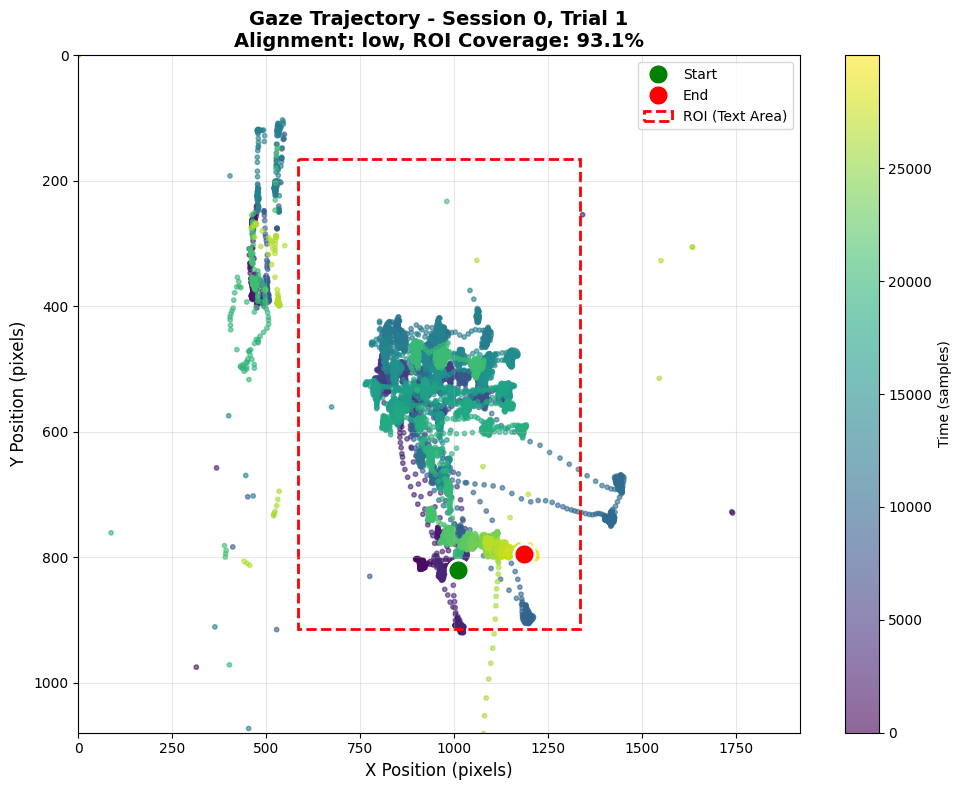

✓ Saved figure to ./figures/gaze_trajectory_example.png


In [ ]:
# Visualize first trial from Session 0
if 0 in all_sessions_data and len(all_sessions_data[0]) > 0:
    trial = all_sessions_data[0][1]  # Second trial for variety
    fig, ax = plot_trial_gaze(trial)
    plt.savefig('./figures/gaze_trajectory_example.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('✓ Saved figure to ./figures/gaze_trajectory_example.png')
else:
    print('No trial data available')

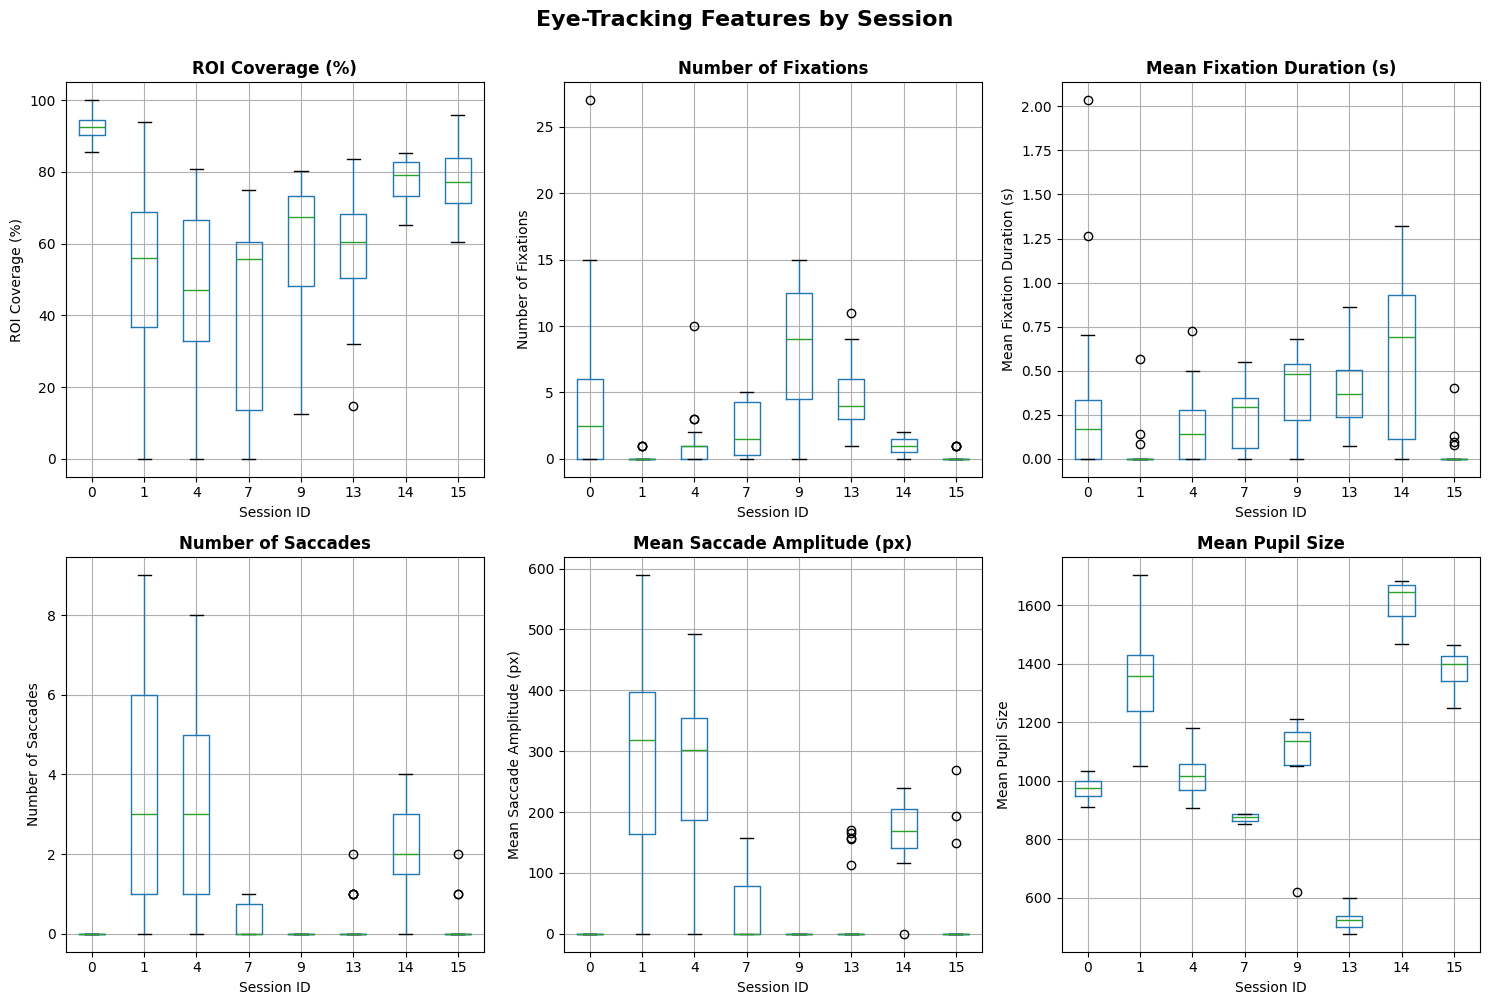

✓ Saved figure to ./figures/eye_tracking_features_by_session.png


In [ ]:
# Plot feature distributions across sessions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

features_to_plot = [
    ('roi_coverage', 'ROI Coverage (%)'),
    ('fixation_count', 'Number of Fixations'),
    ('fixation_duration_mean', 'Mean Fixation Duration (s)'),
    ('saccade_count', 'Number of Saccades'),
    ('saccade_amplitude_mean', 'Mean Saccade Amplitude (px)'),
    ('pupil_size_mean', 'Mean Pupil Size')
]

for idx, (feature, label) in enumerate(features_to_plot):
    ax = axes[idx]
    
    # Box plot by session
    df_features.boxplot(column=feature, by='session_id', ax=ax)
    ax.set_title(label, fontsize=12, fontweight='bold')
    ax.set_xlabel('Session ID', fontsize=10)
    ax.set_ylabel(label, fontsize=10)
    ax.get_figure().suptitle('')  # Remove default title
    
plt.suptitle('Eye-Tracking Features by Session', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('./figures/eye_tracking_features_by_session.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ Saved figure to ./figures/eye_tracking_features_by_session.png')

## 8. Summary & Notes

### Analysis Summary

This notebook processes eye-tracking data from SR Research EyeLink recordings, synchronized with experimental stimulus presentation.

**Data Processed:**
- Sessions: 8 (with eye-tracking data)
- Total trials: 126
- Features extracted: 24 per trial

**Feature Extraction Method:**
- **Algorithm:** I-DT (Identification by Dispersion Threshold) with velocity filtering
- **Fixation detection:** velocity < 35 px/sample AND dispersion < 25px
- **Saccade detection:** velocity ≥ 50 px/sample
- **Data cleaning:** Off-screen coordinates (-1, -1) and invalid pupil sizes removed before processing

**Output Files:**
- `./preprocessed/eye_tracking_features.pkl` - Primary features (Python pickle format)
- `./preprocessed/eye_tracking_features.csv` - Features in CSV format for inspection
- `./figures/gaze_trajectory_example.png` - Example gaze trajectory plot
- `./figures/eye_tracking_features_by_session.png` - Feature distributions by session

**Features Extracted per Trial:**
- **Fixation metrics:** count, duration (mean/median), dispersion (X/Y), time to first
- **Saccade metrics:** count, amplitude (mean/max), peak velocity
- **Pupil metrics:** size (mean/std)
- **Data quality:** % missing samples
- **Trial metadata:** session, trial index, alignment condition, ROI coverage

### Notes

- Data quality varies by session: 4-46% missing samples (blinks, tracking losses)
- Sessions 1, 15 show more frequent tracking losses but features are still valid
- ROI coverage ranges from 41-93% across sessions (text stimulus area)
- Ready for statistical analysis comparing alignment conditions or correlating with EEG measures